# Outcome Prediction with RGCN Model

## 1. Load data from "processed_data"

In [1]:
import time
import math
import joblib
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

import torch
import torch.nn.functional as F
from torch.nn import Parameter, Linear

from torch_geometric.data import Data
from torch_geometric.logging import log
from torch_geometric.nn import RGCNConv
from torch_geometric.utils import to_undirected

In [2]:
num_patients = 1000
inverse_triples=True
embed_dim = 100

entity = pd.read_csv(f'processed_data/sphn_entities_{num_patients}_noOutcome.tsv', sep='\t', header=None)
entity = entity.set_index(entity[0])
entity = entity.to_dict()[1]

indices = []
for i in range(num_patients):
    idx = f'<http://nvasc.org/synth_patient_{i}>'
    indices.append(entity[idx])

events = pd.read_csv(f'processed_data/sphn_events_{num_patients}_noOutcome.tsv', sep='\t', header=None)
y = joblib.load(f'../Data Generation/outcomes_{num_patients}_0.joblib')
num_x = torch.Tensor(np.load(f'processed_data/sphn_numeric_{num_patients}.npy'))

non_test_X, test_X, non_test_y, test_y_ = train_test_split(indices, y, stratify=y, test_size=0.1, random_state=0)
train_X, valid_X, train_y_, valid_y_ = train_test_split(non_test_X, non_test_y, stratify=non_test_y, test_size=1./9)
class_weight = compute_class_weight(class_weight="balanced", classes=np.unique(train_y_), y=train_y_)

edge_index = torch.vstack((torch.Tensor(events[0]).long(),torch.Tensor(events[2]).long()))
edge_type = torch.Tensor(events[1]).long()
train_idx = torch.Tensor(train_X).long()
train_y = torch.Tensor(train_y_).long()
valid_idx = torch.Tensor(valid_X).long()
valid_y = torch.Tensor(valid_y_).long()
test_idx = torch.Tensor(test_X).long()
test_y = torch.Tensor(test_y_).long()
num_nodes = len(entity)

if inverse_triples == True:
    edge_index = to_undirected(edge_index)
    edge_type = torch.cat((edge_type, edge_type))

data = Data(
    edge_index=edge_index,
    edge_type=edge_type,
    train_idx=train_idx,
    train_y=train_y,
    valid_idx=valid_idx,
    valid_y=valid_y,
    test_idx=test_idx,
    test_y=test_y,
    num_nodes=num_nodes,
)
embedding = Parameter(torch.empty(num_nodes, embed_dim))
torch.nn.init.xavier_uniform_(embedding, gain=math.sqrt(2.0))
data.x = embedding
data.num_x = num_x.view(-1,1)
data.num_relations = data.num_edge_types
data.num_classes = 3
print(data)

Data(edge_index=[2, 221870], edge_type=[221870], train_idx=[800], train_y=[800], valid_idx=[100], valid_y=[100], test_idx=[100], test_y=[100], num_nodes=33563, x=[33563, 100], num_x=[33563, 1], num_relations=10, num_classes=3)


## 2. Training the model

In [4]:
class Net(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.num_lin = Linear(1, embed_dim)
        self.conv1 = RGCNConv(embed_dim, 32, data.num_relations,
                          num_bases=30)
        self.conv2 = RGCNConv(32, 32, data.num_relations,
                          num_bases=30)
        # self.conv3 = RGCNConv(16, 16, data.num_relations,
        #                   num_bases=4)
        self.conv4 = RGCNConv(32, data.num_classes, data.num_relations,
                          num_bases=30)

    def forward(self, edge_index, edge_type):
        x = F.relu(self.num_lin(data.num_x))
        x = x + data.x
        x = F.relu(self.conv1(data.x, edge_index, edge_type))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.conv2(x, edge_index, edge_type))
        x = F.dropout(x, training=self.training)
        # x = F.relu(self.conv3(x, edge_index, edge_type))
        # x = F.dropout(x, training=self.training)
        x = self.conv4(x, edge_index, edge_type)
        # return F.log_softmax(x, dim=1)
        return x


if torch.cuda.is_available():
    device = torch.device('cuda')
elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

model, data = Net().to(device), data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.edge_index, data.edge_type)
    loss = F.cross_entropy(out[data.train_idx], data.train_y, weight=torch.Tensor(class_weight).to(device), label_smoothing=0.2)
    loss.backward()
    optimizer.step()
    return float(loss)


@torch.no_grad()
def test():
    model.eval()
    pred = model(data.edge_index, data.edge_type).argmax(dim=-1)
    train_acc = float((pred[data.train_idx] == data.train_y).float().mean())
    val_acc = float((pred[data.valid_idx] == data.valid_y).float().mean())
    test_acc = float((pred[data.test_idx] == data.test_y).float().mean())
    return train_acc, val_acc, test_acc

times = []
best_val_acc = final_test_acc = 0
for epoch in range(1, 501):
    start = time.time()
    loss = train()
    train_acc, val_acc, tmp_test_acc = test()
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        test_acc = tmp_test_acc
        torch.save(model.state_dict(), f'processed_data/model_weights_rgcn_{num_patients}.pth')
    log(Epoch=epoch, Loss=loss, Train=train_acc, Val=val_acc, Test=test_acc)
    times.append(time.time() - start)
print(f"Median time per epoch: {torch.tensor(times).median():.4f}s")

Epoch: 001, Loss: 1.2202, Train: 0.3762, Val: 0.4000, Test: 0.3400
Epoch: 002, Loss: 1.2049, Train: 0.2937, Val: 0.3200, Test: 0.3400
Epoch: 003, Loss: 1.2019, Train: 0.2237, Val: 0.2100, Test: 0.3400
Epoch: 004, Loss: 1.1987, Train: 0.1637, Val: 0.1600, Test: 0.3400
Epoch: 005, Loss: 1.1903, Train: 0.1325, Val: 0.1400, Test: 0.3400
Epoch: 006, Loss: 1.1844, Train: 0.1225, Val: 0.1300, Test: 0.3400
Epoch: 007, Loss: 1.1790, Train: 0.1163, Val: 0.1200, Test: 0.3400
Epoch: 008, Loss: 1.1782, Train: 0.1150, Val: 0.1200, Test: 0.3400
Epoch: 009, Loss: 1.1804, Train: 0.1150, Val: 0.1200, Test: 0.3400
Epoch: 010, Loss: 1.1777, Train: 0.1150, Val: 0.1200, Test: 0.3400
Epoch: 011, Loss: 1.1735, Train: 0.1150, Val: 0.1200, Test: 0.3400
Epoch: 012, Loss: 1.1725, Train: 0.1150, Val: 0.1200, Test: 0.3400
Epoch: 013, Loss: 1.1751, Train: 0.1150, Val: 0.1200, Test: 0.3400
Epoch: 014, Loss: 1.1760, Train: 0.1150, Val: 0.1200, Test: 0.3400
Epoch: 015, Loss: 1.1623, Train: 0.1150, Val: 0.1200, Test: 0.

## 3. Results - AUC / Confusion matrix

In [5]:
from sklearn.metrics import roc_auc_score

model = Net().to(device)
model.load_state_dict(torch.load(f'processed_data/model_weights_rgcn_{num_patients}.pth', weights_only=True))
model.eval()
with torch.no_grad():
    out = model(data.edge_index, data.edge_type).cpu()
    prob = F.softmax(out, dim=1)
auc = roc_auc_score(data.test_y.cpu(), prob[data.test_idx.cpu()], multi_class='ovr')
print(f'ROC AUC score: {auc:.4f}')

ROC AUC score: 0.5266


0
0    46
1    43
2    11
Name: count, dtype: int64


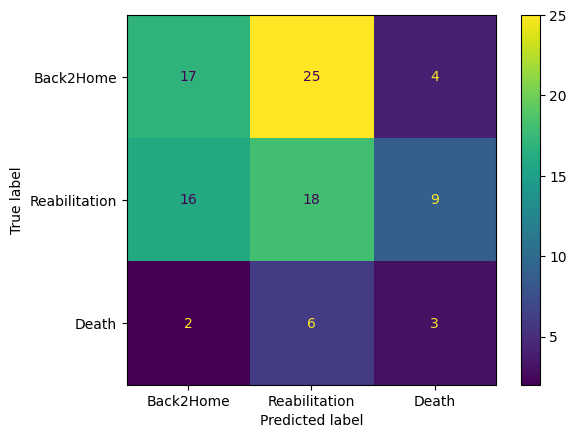

In [7]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

print(pd.DataFrame(test_y.cpu()).value_counts())

model.eval()
pred = model(data.edge_index, data.edge_type).argmax(dim=-1)
matrix = confusion_matrix(data.test_y.cpu(), pred[data.test_idx].cpu())
disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=["Back2Home", "Reabilitation", "Death"])
disp.plot()
plt.show()